The University of Texas at Austin

Rishi Vangala (MIS)

________________________________________________________________________________________________________________________________________________________


Guiding Question: What are the main characteristics of trending videos on YouTube and how can we form a strategy to help marketers, media, and creators maximize the likelihood of a video going viral?

We load important libraries and the dataset and we also display the first 5 records and all column. The Dataset is from Kaggle and it contains trending YouTube over the past few years.

In [4]:
import pandas as pd
import json
import statsmodels.api as sm
from patsy import dmatrices
from sklearn import neighbors
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%pylab inline
df = pd.read_csv("US_youtube_trending_data.csv")
with open('US_category_id.json', 'r') as f:
    categories_data = json.load(f)
category_mapping = {}
for item in categories_data['items']:
    category_id = int(item['id'])  # convert to int for matching
    category_name = item['snippet']['title']
    category_mapping[category_id] = category_name
df["category_name"] = df["categoryId"].map(category_mapping)
df = df[df["view_count"] != 0]
trends = df["category_name"].value_counts()
df = df.groupby("video_id")["view_count"].max().reset_index().merge(df,
                                                     left_on = ["video_id", "view_count"],
                                                     right_on = ["video_id", "view_count"])
category_avg = df.groupby("category_name")[["view_count", "likes", "dislikes", "comment_count"]].mean()
df.iloc[:5]


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


,video_id,view_count,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,category_name
0,--14w5SOEUs,6823249,Migos - Avalanche (Official Video),2021-06-10T16:00:00Z,UCGIelM2Dj3zza3xyV3pL3WQ,MigosVEVO,10,2021-06-15T00:00:00Z,Migos|Avalanche|Quality|Control|Music/Motown|R...,262692,4107,16445,https://i.ytimg.com/vi/--14w5SOEUs/default.jpg,False,False,Watch the the official video for Migos - Avala...,Music
1,--2O86Z0hsM,538485,MY TESLA PAYS FOR ITSELF,2022-03-09T23:19:08Z,UCXJEvxZSozjAAqhbMfhIArA,jf.okay,24,2022-03-15T00:00:00Z,[None],17290,0,1439,https://i.ytimg.com/vi/--2O86Z0hsM/default.jpg,False,False,NaN,Entertainment
2,--40TEbZ9Is,682609,Supporting Actress in a Comedy: 73rd Emmys,2021-09-20T01:03:32Z,UClBKH8yZRcM4AsRjDVEdjMg,Television Academy,24,2021-09-25T00:00:00Z,[None],8029,369,723,https://i.ytimg.com/vi/--40TEbZ9Is/default.jpg,False,False,Hannah Waddingham wins the Emmy for Supporting...,Entertainment
3,--47FjCWgrU,1940781,San Francisco 49ers vs. Arizona Cardinals Game...,2023-12-18T00:21:58Z,UCDVYQ4Zhbm3S2dlz7P1GBDg,NFL,17,2023-12-25T00:00:00Z,[None],22612,0,2018,https://i.ytimg.com/vi/--47FjCWgrU/default.jpg,False,False,Check out our other channels:NFL Mundo https:/...,Sports
4,--5-brQiQFg,1280997,Washington Commanders vs. San Francisco 49ers ...,2022-12-25T00:30:17Z,UCDVYQ4Zhbm3S2dlz7P1GBDg,NFL,17,2022-12-26T00:00:00Z,[None],14603,0,2078,https://i.ytimg.com/vi/--5-brQiQFg/default.jpg,False,False,Check out our other channels:NFL Mundo https:/...,Sports


________________________________________________________________________________________________________________________________________________________

Subcategory EDA 1: Video Category Impact
- Do certain video categories have better reach others?


Lets visualize our data to focus on reach:

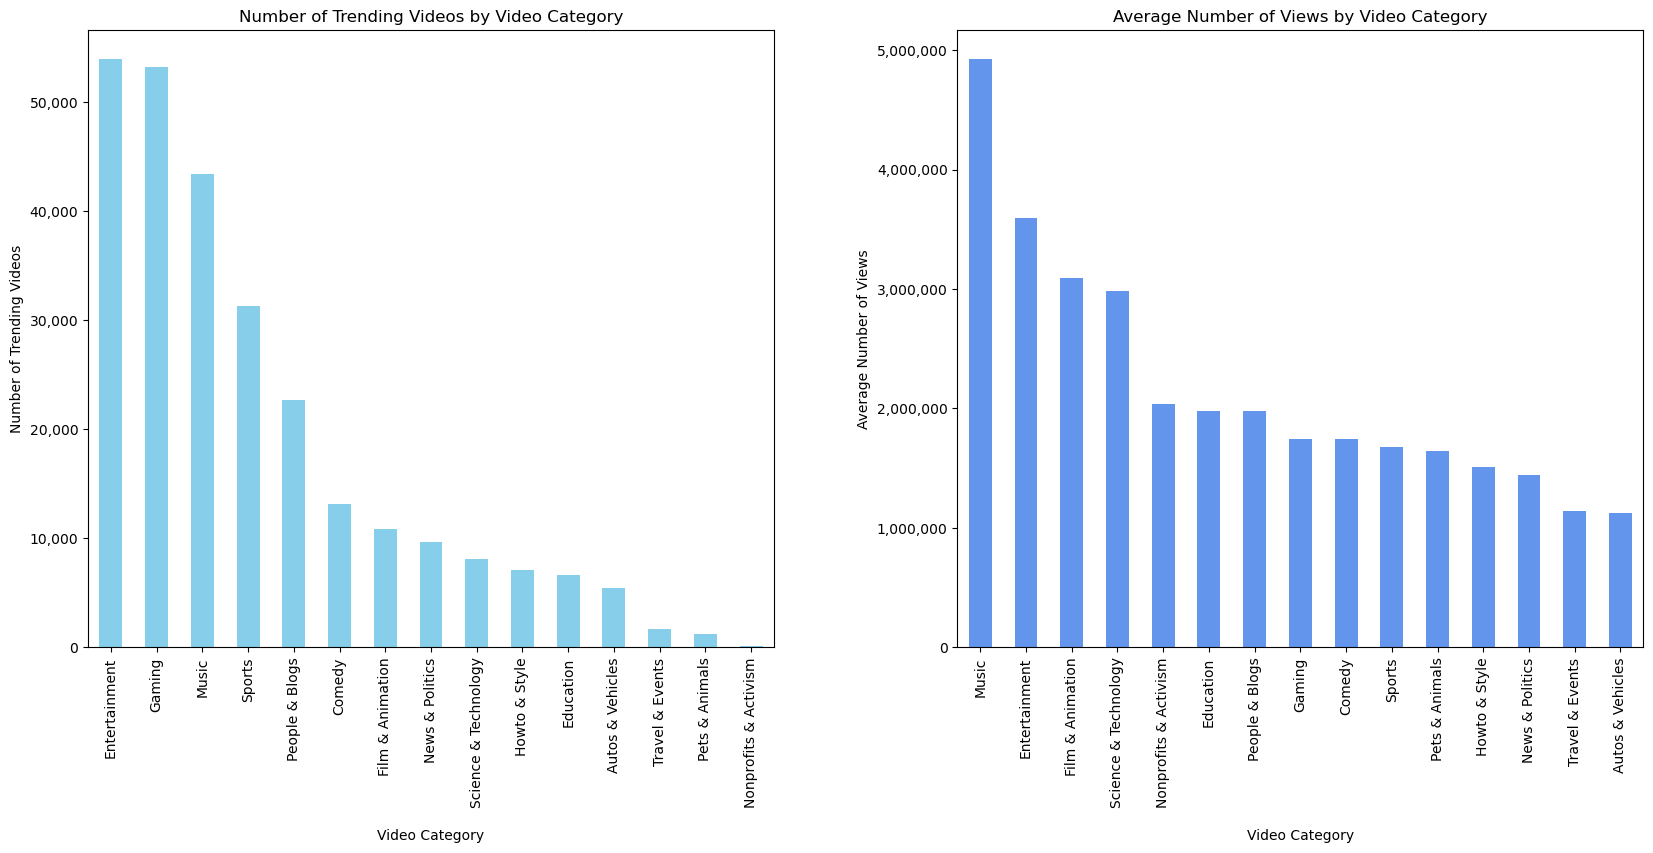

In [8]:
colors = ['#87CEEB', '#6495ED', '#1E90FF', '#4682B4', '#4169E1']

fig, axs = plt.subplots(1, 2, figsize = (18, 10))

trends.plot(y = trends.values, kind = "bar", color = colors[0], ax = axs[0])
axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
axs[0].set_title("Number of Trending Videos by Video Category")
axs[0].set_xlabel("Video Category", labelpad = 15)
axs[0].set_ylabel("Number of Trending Videos")
axs[0].tick_params(axis='x', rotation=90)
plt.tight_layout(pad=6)

category_avg.sort_values(by = "view_count", ascending = False).plot(y = "view_count", kind = "bar", color = colors[1], ax = axs[1])
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
axs[1].set_title("Average Number of Views by Video Category")
axs[1].set_xlabel("Video Category", labelpad = 15)
axs[1].set_ylabel("Average Number of Views")
axs[1].tick_params(axis='x', rotation=90)
axs[1].get_legend().remove()
plt.tight_layout(pad=6)


On our left plot, we can see that most videos considered trending were in Entertainment, Gaming, Music, and Sports. On our right plot, we can see that Music and Entertainment lead categories in drawing in more reach as they average the highest number of views by video category.

Lets take a look at like ratio vs views to see if they positively correlate. Most of the time more views has more likes but that does not determine engagement. The ratio is a good indicator:


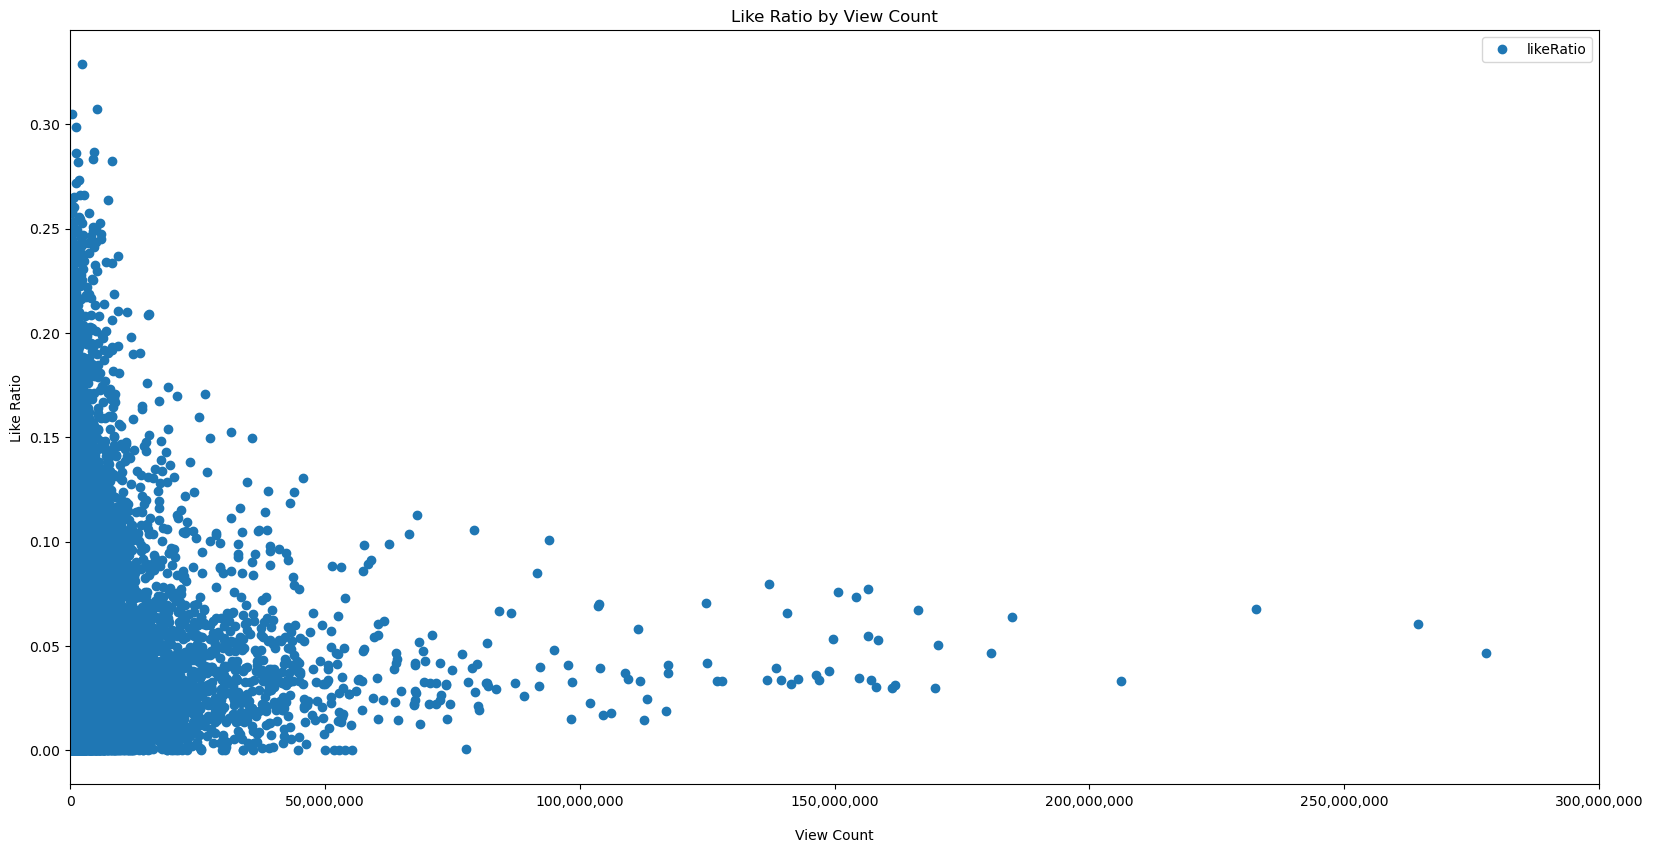

In [11]:
df["likeRatio"] = df["likes"] / df["view_count"]

fig, ax = plt.subplots(1, 1, figsize = (18, 10))
df.plot(x="view_count", y="likeRatio", marker = "o", linestyle = "None", ax=ax)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
ax.set_title("Like Ratio by View Count")
ax.set_xlabel("View Count", labelpad = 15)
ax.set_ylabel("Like Ratio")
ax.set_xlim(0, 300_000_000)
plt.tight_layout(pad=6)

Though more views have more likes, that does not determine engagement. We can see that generally
the more views a video has, the lesser the like ratio is. This can be explained by the fact that trending videos get pushed more to everyone outside of a channel’s fans, meaning that many more people watch the video but those people may not be as interested or engaged. At the same time, a person’s account may be rewatching the video, increasing views but, as an account can only leave one like, not increasing likes.


________________________________________________________________________________________________________________________________________________________

Subcategory EDA 2: Engagement Ratios
- What Video Categories draw in the most engagement from their viewers?

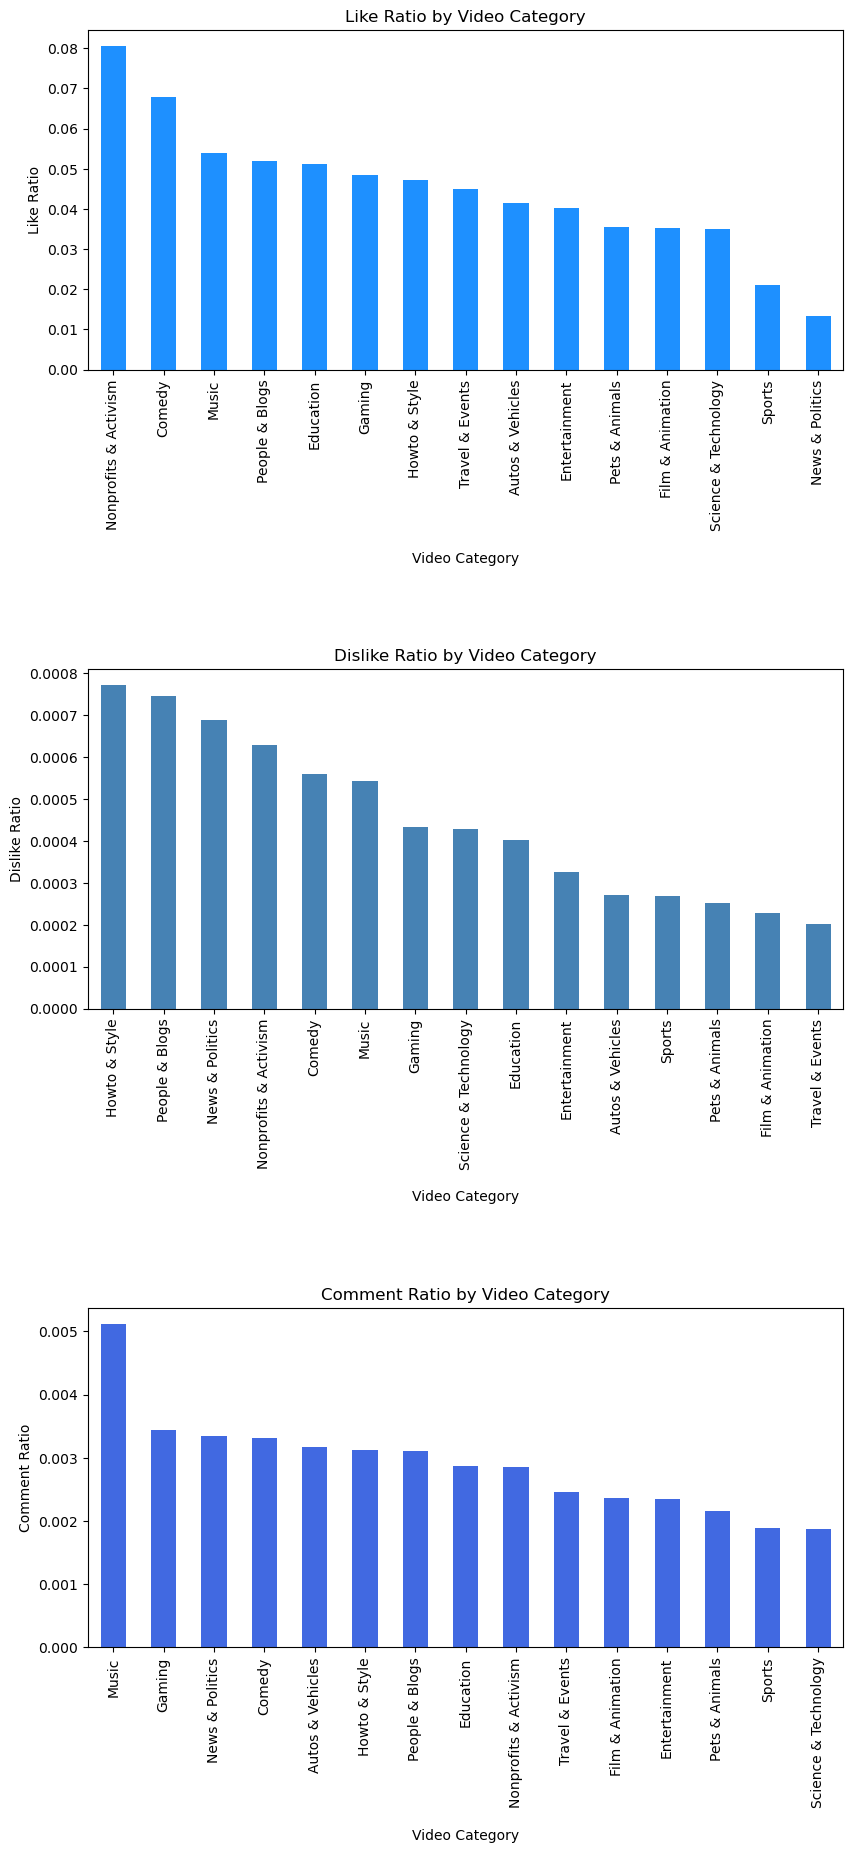

In [14]:
fig, axs = plt.subplots(3, 1, figsize = (10, 20))

category_avg["like_ratio"] = category_avg["likes"] / category_avg["view_count"]
category_avg["like_ratio"].sort_values(ascending = False).plot(kind = "bar", color = colors[2], ax = axs[0])
axs[0].set_title("Like Ratio by Video Category")
axs[0].set_xlabel("Video Category", labelpad = 15)
axs[0].set_ylabel("Like Ratio")
plt.tight_layout(pad=6)

category_avg["dislike_ratio"] = category_avg["dislikes"] / category_avg["view_count"]
category_avg["dislike_ratio"].sort_values(ascending = False).plot(kind = "bar", color = colors[3], ax = axs[1])
axs[1].set_title("Dislike Ratio by Video Category")
axs[1].set_xlabel("Video Category", labelpad = 15)
axs[1].set_ylabel("Dislike Ratio")
plt.tight_layout(pad=6)

category_avg["comment_ratio"] = category_avg["comment_count"] / category_avg["view_count"]
category_avg["comment_ratio"].sort_values(ascending = False).plot(kind = "bar", color = colors[4], ax = axs[2])
axs[2].set_title("Comment Ratio by Video Category")
axs[2].set_xlabel("Video Category", labelpad = 15)
axs[2].set_ylabel("Comment Ratio")
plt.tight_layout(pad=6)



In our top plot, we can see that Comedy, Music, Education, Nonprofits and Activism, and People & Blogs have the highest like to views ratio indicating that those categories are effective in bringing in engagement. Looking at the middle plot which focuses on dislike ratio, the ratio is very small for all categories where it does not seem as significant to pay attention to. For 1 million views, the category with the highest dislike ratio would have 800 dislikes on average and some of them can be attributed to accidents. In our bottom plot, We can see music generates the highest comment ratio indicating increased engagement in that category.

________________________________________________________________________________________________________________________________________________________

Subcategory EDA 3: Posting Time Impact
Questions of Focus: 
- At what time of the day is it most optimal to post to maximize performance and limit competition?
- When is the best time to post a video to maximize the potential of the video being trending?

We will do a time series analysis across the hours of a day.

Text(0, 0.5, 'Total Number of Views')

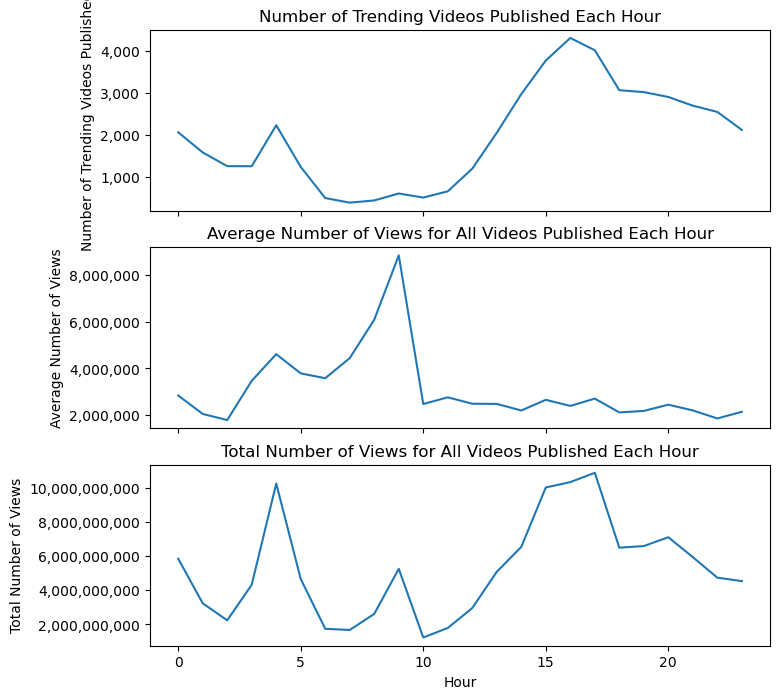

In [18]:
df["publishedAt"] = pd.to_datetime(df["publishedAt"])
df["publishedHour"] = df["publishedAt"].dt.hour


fig, axs = plt.subplots(3, 1, figsize = (8, 8),
                       sharex = True)
df["publishedHour"].value_counts().sort_index().plot(ax = axs[0])
axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
axs[0].set_title("Number of Trending Videos Published Each Hour")
axs[0].set_xlabel("Hour")
axs[0].set_ylabel("Number of Trending Videos Published")

df.groupby("publishedHour")["view_count"].mean().plot(ax = axs[1])
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
axs[1].set_title("Average Number of Views for All Videos Published Each Hour")
axs[1].set_xlabel("Hour")
axs[1].set_ylabel("Average Number of Views")

df.groupby("publishedHour")["view_count"].sum().plot(ax = axs[2])
axs[2].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
axs[2].set_title("Total Number of Views for All Videos Published Each Hour")
axs[2].set_xlabel("Hour")
axs[2].set_ylabel("Total Number of Views")


In our top plot, we can see that most trending videos are published around the 15th hour and after which is after 3:00 p.m. which also indicates high competition during those times. However, the average number of views for all videos published each hour shows that the average number of views is highest around 4 hour to 9 hour mark with a shar peak at the 9th hour. This could indicate that videos are more likely to get exposure and reach if published early morning as opposed to later times when trending video publishing is more common. Lastly the final plot shows most views happen early morning around hour 4 or after hour 15 which could indicate the most amount of traffic for people viewing these videos.

C:\Users\rvmin\AppData\Local\Temp\ipykernel_7596\260099222.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("publishedDay")["view_count"].mean().sort_index().plot(ax = axs[0])
C:\Users\rvmin\AppData\Local\Temp\ipykernel_7596\260099222.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("publishedDay")["view_count"].sum().sort_index().plot(ax = axs[1])


Text(0, 0.5, 'Total Number of Views')

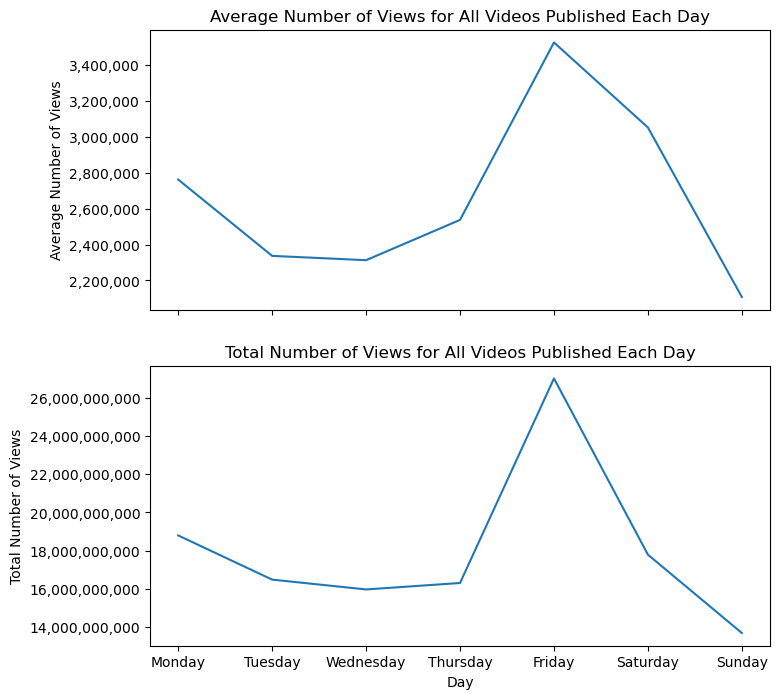

In [20]:
fig, axs = plt.subplots(2, 1, figsize = (8, 8),
                       sharex = True)

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df["publishedDay"] = pd.Categorical(df["publishedAt"].dt.day_name(), categories = day_order, ordered = True)
df.groupby("publishedDay")["view_count"].mean().sort_index().plot(ax = axs[0])
axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
axs[0].set_title("Average Number of Views for All Videos Published Each Day")
axs[0].set_xlabel("Day")
axs[0].set_ylabel("Average Number of Views")

df.groupby("publishedDay")["view_count"].sum().sort_index().plot(ax = axs[1])
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
axs[1].set_title("Total Number of Views for All Videos Published Each Day")
axs[1].set_xlabel("Day")
axs[1].set_ylabel("Total Number of Views")

The plots show that the highest reach, traffic, and views for trending videos happen around Friday and Saturday. This could be attributed to the fact that during the weekend, people have time off their regular responsibilities.

C:\Users\rvmin\AppData\Local\Temp\ipykernel_7596\458466279.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heat_df = df.groupby(['publishedDay', 'publishedHour'])['view_count'].mean().unstack()


Text(345.72222222222223, 0.5, 'Day of Week')

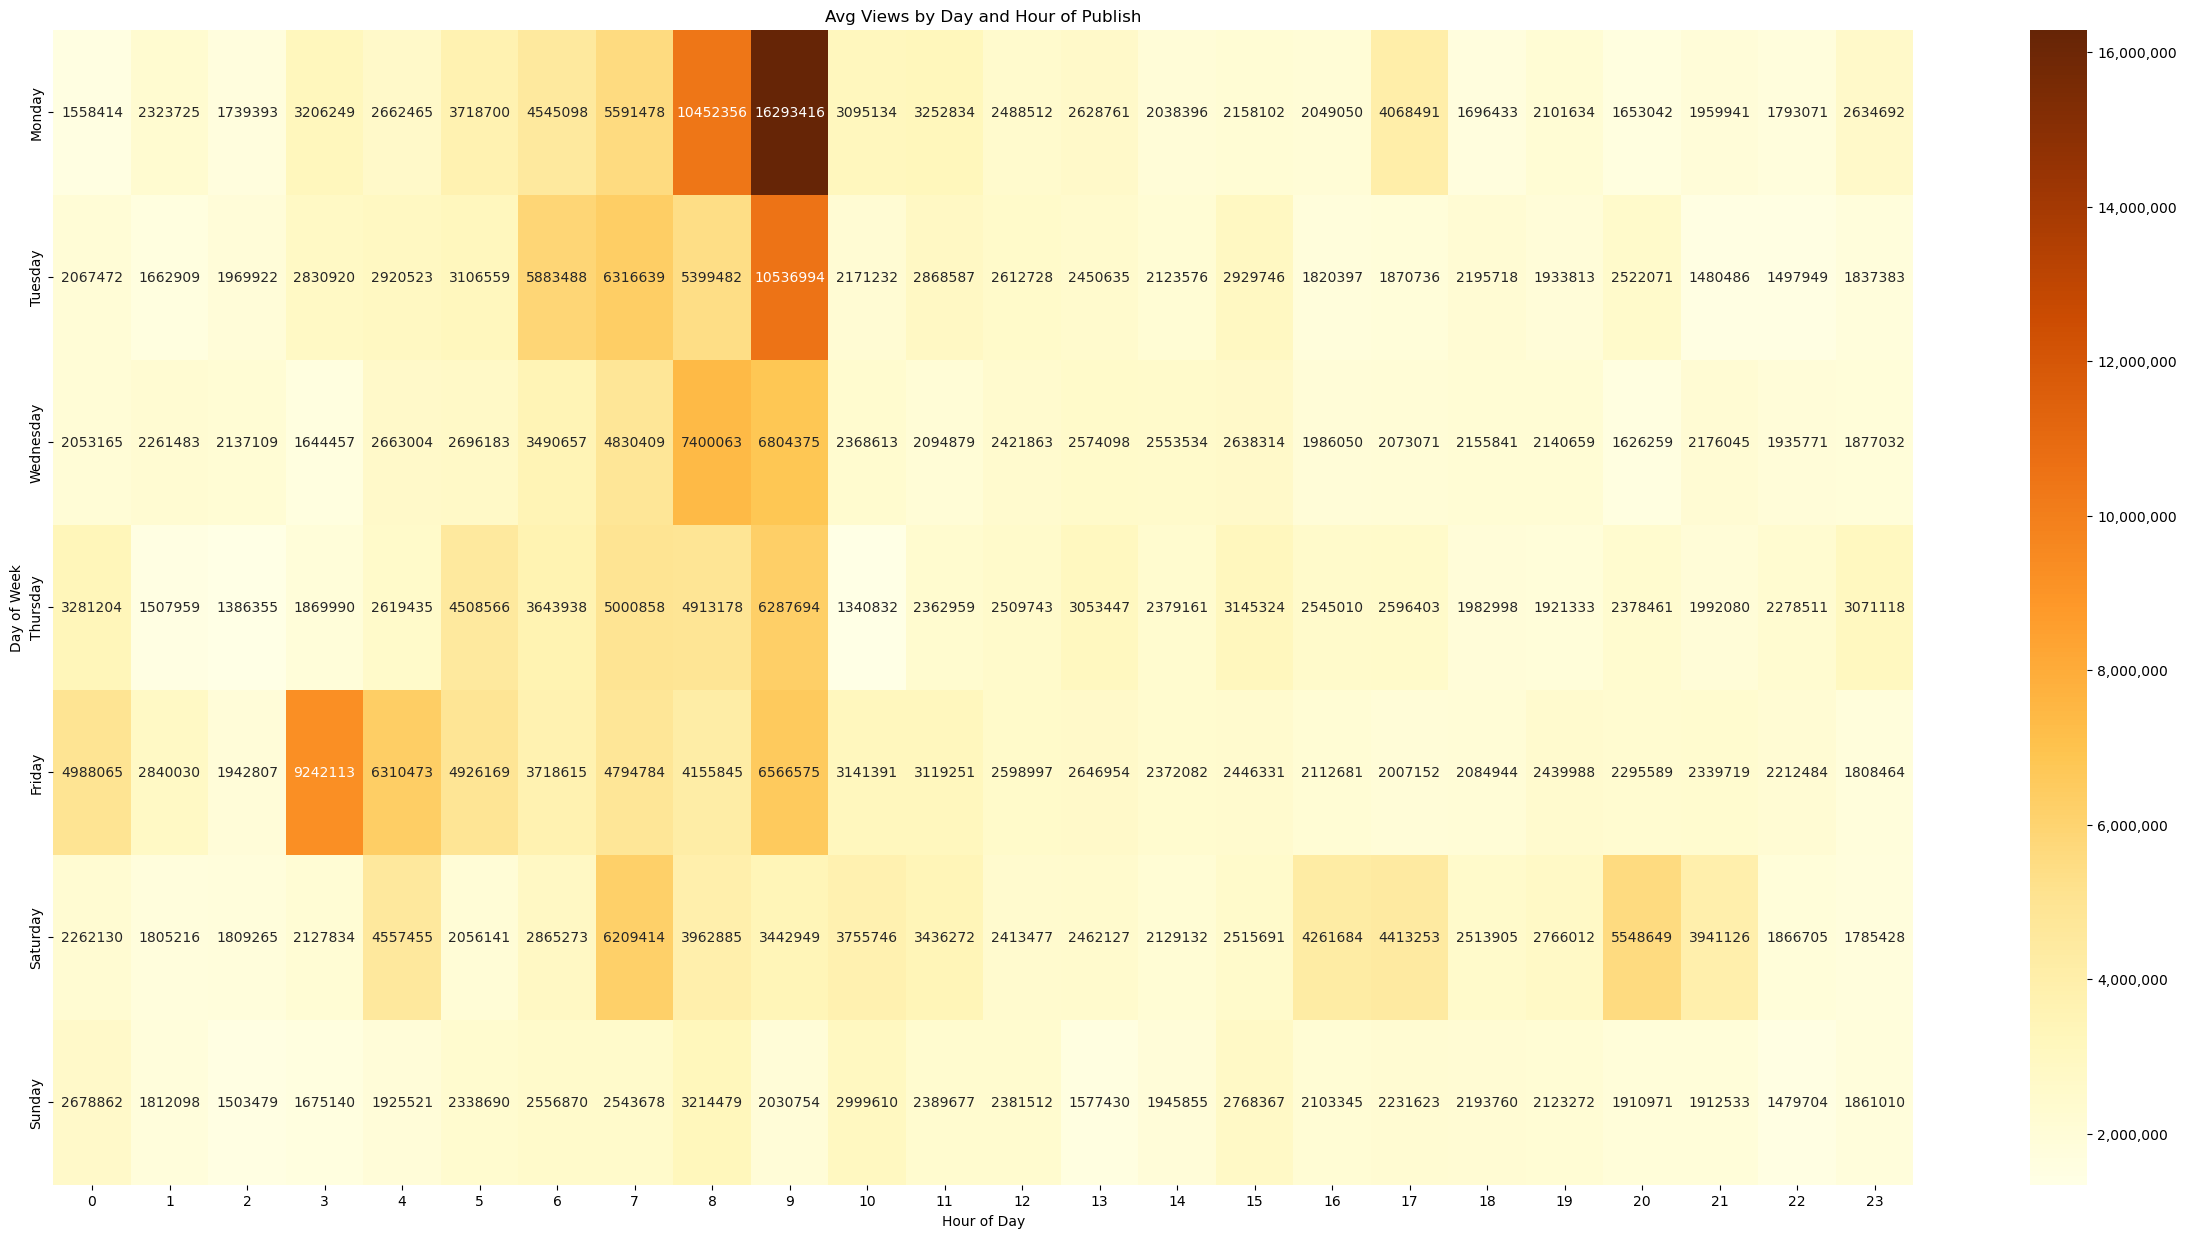

In [22]:
heat_df = df.groupby(['publishedDay', 'publishedHour'])['view_count'].mean().unstack()
import seaborn as sns

plt.figure(figsize=(30,15))
ax = sns.heatmap(heat_df.loc[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']], cmap='YlOrBr', annot=True, fmt=".0f")
colorbar = ax.collections[0].colorbar
colorbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax.set_title("Avg Views by Day and Hour of Publish")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Day of Week")

The heatmap shows that Monday, Tuesday, Wednesday, and Friday, mornings are ideal times to publish due to the resulting high average views for videos published at those times.

Earlier we saw that videos in the Entertainment, Gaming, Music, and Sports category made up most of the videos considered trending. Lets take a look at their optimal times:

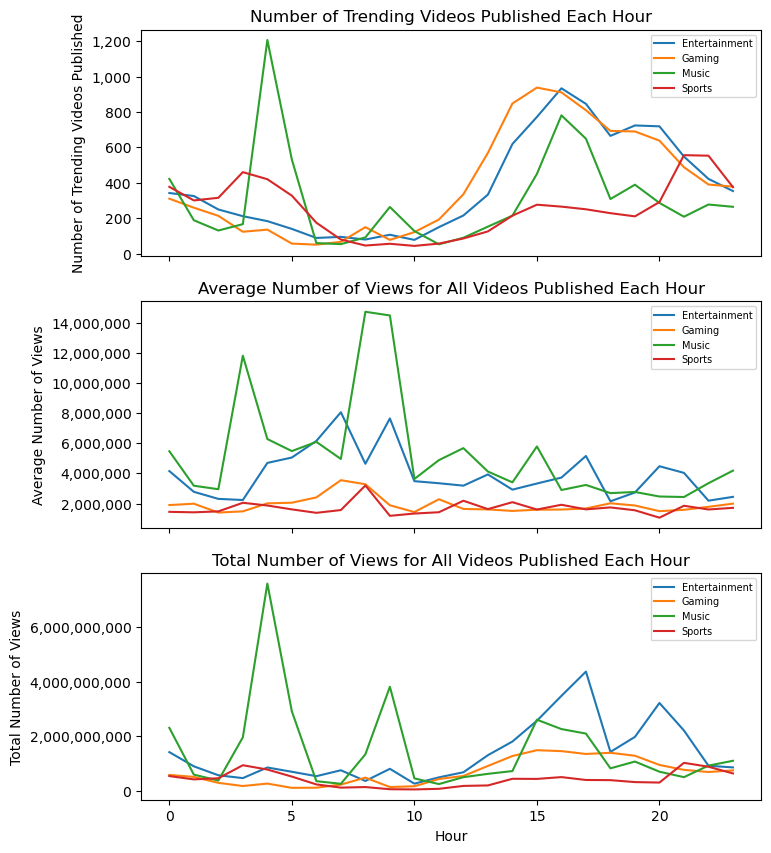

In [25]:
fig, axs = plt.subplots(3, 1, figsize = (8, 10),
                       sharex = True)
ent = df[df["category_name"] == "Entertainment"]
gam = df[df["category_name"] == "Gaming"]
mus = df[df["category_name"] == "Music"]
spo = df[df["category_name"] == "Sports"]

ent["publishedHour"].value_counts().sort_index().plot(ax = axs[0], label = "Entertainment")
gam["publishedHour"].value_counts().sort_index().plot(ax = axs[0], label = "Gaming")
mus["publishedHour"].value_counts().sort_index().plot(ax = axs[0], label = "Music")
spo["publishedHour"].value_counts().sort_index().plot(ax = axs[0], label = "Sports")
axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
axs[0].set_title("Number of Trending Videos Published Each Hour")
axs[0].set_xlabel("Hour")
axs[0].set_ylabel("Number of Trending Videos Published")
axs[0].legend(loc = "upper right", fontsize=7, markerscale=0.7)

ent.groupby("publishedHour")["view_count"].mean().plot(ax = axs[1], label = "Entertainment")
gam.groupby("publishedHour")["view_count"].mean().plot(ax = axs[1], label = "Gaming")
mus.groupby("publishedHour")["view_count"].mean().plot(ax = axs[1], label = "Music")
spo.groupby("publishedHour")["view_count"].mean().plot(ax = axs[1], label = "Sports")
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
axs[1].set_title("Average Number of Views for All Videos Published Each Hour")
axs[1].set_xlabel("Hour")
axs[1].set_ylabel("Average Number of Views")
axs[1].legend(loc = "upper right", fontsize=7, markerscale=0.7)

ent.groupby("publishedHour")["view_count"].sum().plot(ax = axs[2], label = "Entertainment")
gam.groupby("publishedHour")["view_count"].sum().plot(ax = axs[2], label = "Gaming")
mus.groupby("publishedHour")["view_count"].sum().plot(ax = axs[2], label = "Music")
spo.groupby("publishedHour")["view_count"].sum().plot(ax = axs[2], label = "Sports")
axs[2].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
axs[2].set_title("Total Number of Views for All Videos Published Each Hour")
axs[2].set_xlabel("Hour")
axs[2].set_ylabel("Total Number of Views")
axs[2].legend(loc = "upper right", fontsize=7, markerscale=0.7)


In [26]:
mus[mus["publishedHour"] == 4].sort_values(by = "view_count", ascending = False).iloc[:5]

,video_id,view_count,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,category_name,likeRatio,publishedHour,publishedDay
32668,gQlMMD8auMs,277791741,BLACKPINK - ‘Pink Venom’ M/V,2022-08-19 04:00:13+00:00,UCOmHUn--16B90oW2L6FRR3A,BLACKPINK,10,2022-09-10T00:00:00Z,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블...,12993894,0,3534337,https://i.ytimg.com/vi/gQlMMD8auMs/default.jpg,False,False,BLACKPINK - ‘Pink Venom’ M/VKick in the door W...,Music,0.046776,4,Friday
43867,vRXZj0DzXIA,184778248,BLACKPINK - 'Ice Cream (with Selena Gomez)' M/V,2020-08-28 04:00:11+00:00,UCOmHUn--16B90oW2L6FRR3A,BLACKPINK,10,2020-09-05T00:00:00Z,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블...,11795670,879354,2735997,https://i.ytimg.com/vi/vRXZj0DzXIA/default.jpg,False,False,BLACKPINK - ‘Ice Cream (with Selena Gomez)’Com...,Music,0.063837,4,Friday
19439,POe9SOEKotk,180654898,BLACKPINK - ‘Shut Down’ M/V,2022-09-16 04:00:12+00:00,UCOmHUn--16B90oW2L6FRR3A,BLACKPINK,10,2022-10-15T00:00:00Z,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블...,8438151,0,1326586,https://i.ytimg.com/vi/POe9SOEKotk/default.jpg,False,False,BLACKPINK - ‘Shut Down’Blackpink in your areaB...,Music,0.046709,4,Friday
26353,YudHcBIxlYw,170333822,JISOO - ‘꽃(FLOWER)’ M/V,2023-03-31 04:00:14+00:00,UCOmHUn--16B90oW2L6FRR3A,BLACKPINK,10,2023-04-29T00:00:00Z,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블...,8553612,0,1162689,https://i.ytimg.com/vi/YudHcBIxlYw/default.jpg,False,False,JISOO - ‘꽃(FLOWER)’ ABC 도레미만큼 착했던 나그 눈빛이 싹 변했지...,Music,0.050217,4,Friday
20200,QU9c0053UAU,156481357,정국 (Jung Kook) 'Seven (feat. Latto)' Official MV,2023-07-14 04:00:00+00:00,UC3IZKseVpdzPSBaWxBxundA,HYBE LABELS,10,2023-08-14T00:00:00Z,HYBE|HYBE LABELS|하이브|하이브레이블즈|정국|Jung Kook|Seven,8567581,0,1131961,https://i.ytimg.com/vi/QU9c0053UAU/default.jpg,False,False,정국 (Jung Kook) 'Seven (feat. Latto)' Official ...,Music,0.054751,4,Friday


In the first plot, there is an unusual spike for music videos at 4 AM which can
be explained by the fact that many big music artists, like BLACKPINK, BTS, Madonna, Drake,
and Lady Gaga, have their teams post at that time. From the second plot, we
learn that people watch music and entertainment videos late at night around
3 am potentially waiting for the new music to be posted, then there is a
spike for music from 7 AM to 10 AM, when people wake up, get ready, and
set the tone for their day. Also the spike can just be correlated for videos posted at that time but actual people can watch it later.
In third plot, we see a similar spike the way we
see in the first plot late at night then again in the early morning for music. In
all plots, there is a spike for entertainment
starting at 3 PM, when people first leave school then work, a dip from 6 PM
to 8 PM which are typical dinner times, and then another smaller spike for
entertainment after, when people relax in the evening.


Now we will create 3 categories high performance trending, medium performance trending, and low performance trending and analyze their time of posting:


C:\Users\rvmin\AppData\Local\Temp\ipykernel_7596\3393720237.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  low.groupby("publishedDay")["interactions"].mean().plot(ax = ax[1], label = "Low")
C:\Users\rvmin\AppData\Local\Temp\ipykernel_7596\3393720237.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  med.groupby("publishedDay")["interactions"].mean().plot(ax = ax[1], label = "Medium")
C:\Users\rvmin\AppData\Local\Temp\ipykernel_7596\3393720237.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curren

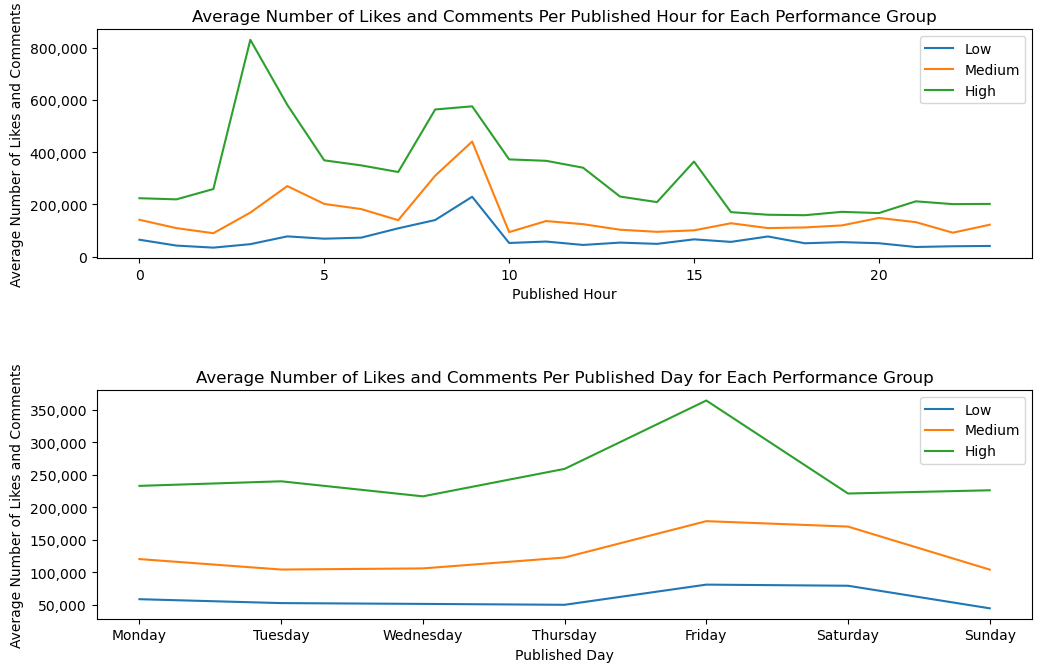

In [29]:
df["engagementScore"] = ((df["likes"] + df["comment_count"]) / df["view_count"]).round(2)
df["engagementScore"].describe().round(3)
df["Performance"] = "Low"
df.loc[(df["engagementScore"] > 0.03) & (df["engagementScore"] <= 0.07), "Performance"] = "Medium"
df.loc[df["engagementScore"] > 0.07, "Performance"] = "High"
df["interactions"] = df["likes"] + df["comment_count"]

fig, ax = plt.subplots(2, 1, figsize = (12, 8))

low = df[df["Performance"] == "Low"]
med = df[df["Performance"] == "Medium"]
high = df[df["Performance"] == "High"]

low.groupby("publishedHour")["interactions"].mean().plot(ax = ax[0], label = "Low")
med.groupby("publishedHour")["interactions"].mean().plot(ax = ax[0], label = "Medium")
high.groupby("publishedHour")["interactions"].mean().plot(ax = ax[0], label = "High")
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
ax[0].set_title("Average Number of Likes and Comments Per Published Hour for Each Performance Group")
ax[0].set_xlabel("Published Hour")
ax[0].set_ylabel("Average Number of Likes and Comments")
ax[0].legend(loc = "upper right", fontsize=10, markerscale=1)
plt.tight_layout(pad=6)
low.groupby("publishedDay")["interactions"].mean().plot(ax = ax[1], label = "Low")
med.groupby("publishedDay")["interactions"].mean().plot(ax = ax[1], label = "Medium")
high.groupby("publishedDay")["interactions"].mean().plot(ax = ax[1], label = "High")
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
ax[1].set_title("Average Number of Likes and Comments Per Published Day for Each Performance Group")
ax[1].set_xlabel("Published Day")
ax[1].set_ylabel("Average Number of Likes and Comments")
ax[1].legend(loc = "upper right", fontsize=10, markerscale=1)



We chose to define trending as an
engagement score which is likes plus comments divided by the views. From
there we separated trending into three categories: high, medium, low. Low
was the lower quartile under .03 of the engagement score, with medium
being in between .03 and .07, and high is the upper quartile above .07. We
thought this approach would allow us to more clearly understand what
classifies a trending video and how those videos are viewed. As seen in
the first plot, all three categories have spikes late at night around 3 AM and
then in the mornings as people get started with their day. Then there's
another spike as people return home from school or work. The second plot,
presents interesting results as we see that high trending videos have a peak
in their views on Friday. This may be attributed to the fact
that people on their days to relax would prefer to engage with
content they are familiar with.


Text(0.5, 1.0, 'Average Engagement Score by Video Category')

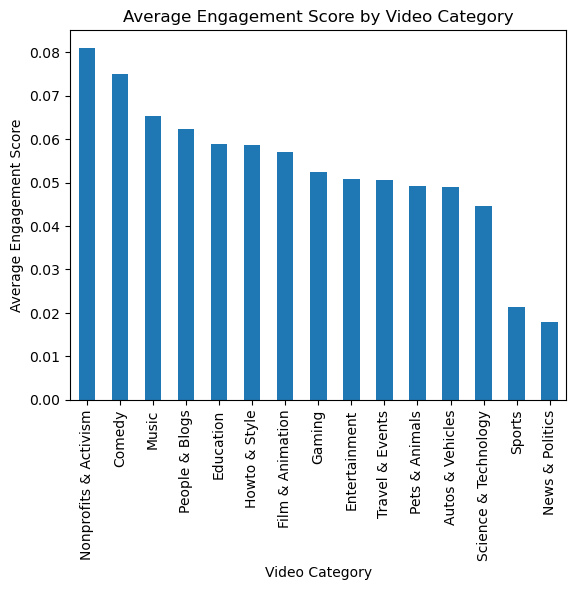

In [31]:
df.groupby("category_name")["engagementScore"].mean().sort_values(ascending = False).plot(kind = "bar")
xlabel("Video Category")
ylabel("Average Engagement Score")
title("Average Engagement Score by Video Category")

________________________________________________________________________________________________________________________________________________________

Subcategory EDA 4: Title Text Analysis
- Lets take a look at the relationship between likes and Number of Words
- Lets look at the most common unique words in the High Performance catagory

Text(0, 0.5, 'Number of Likes')

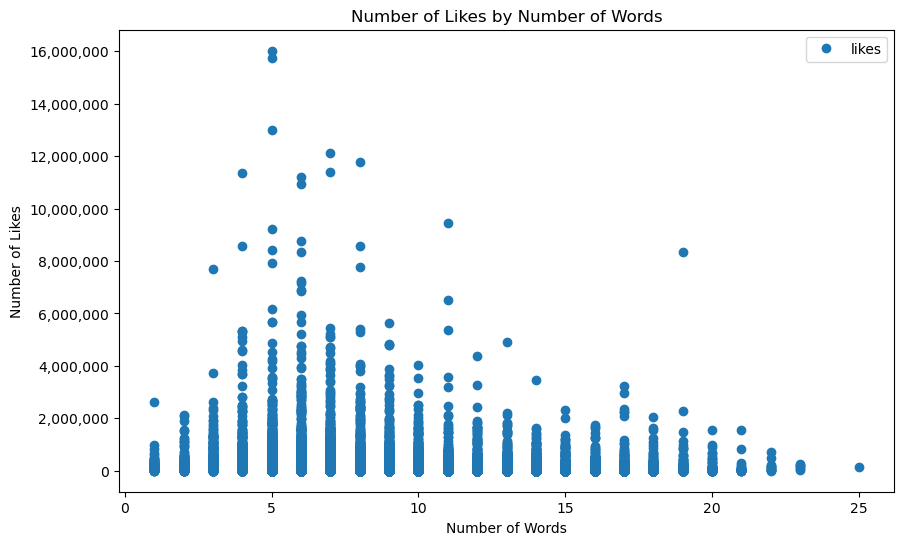

In [34]:
df["titleLen"] = df["title"].str.len()
df["titleWC"] = df["title"].str.split().str.len()


ax = df.plot(x = 'titleWC', y = 'likes', marker = "o", linestyle = "None", figsize=(10,6))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
ax.set_title("Number of Likes by Number of Words")
ax.set_xlabel("Number of Words")
ax.set_ylabel("Number of Likes")

Content with 3 to 8 words, as well as a spike
at 11 words and 19 words, tend to have more likes as people are more interested in videos
with shorter to medium titles. 

Text(0, 0.5, 'Occurences')

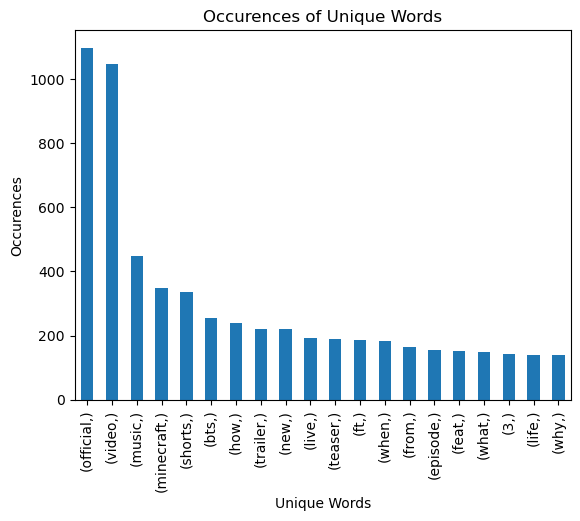

In [36]:
import string
import re
topTitles = df[df["Performance"] == "High"]["title"]
words = []
top_words = ['me', '1', 'm', 'it', 'x', 't', 'mv','2', 'we', 'our', 'your', 'my', 'you', 's', 'i', 'the', 'and', 'to', 'of', 'in', 'is', 'a', 'for', 'on', 'with', 'at', 'by', 'an', 'be', 'this', 'that']
for row in topTitles:
    titleWords = row.lower()
    titleWords = re.sub(f"[{re.escape(string.punctuation)}]", " ", titleWords).split()
    for word in titleWords:
        if word not in top_words:
            words.append(word)
word_df = pd.DataFrame(words, columns = ["word"])
word_df.value_counts()[:20].plot(kind = "bar")
title("Occurences of Unique Words")
xlabel("Unique Words")
ylabel("Occurences")

We can see that the
occurrences of words such as “official” and “video” are more common in the
High trending performance category but through looking at the preceding
words, we understand that videos relating to music, minecraft, shorts, and
movies are also frequent.


________________________________________________________________________________________________________________________________________________________
5: Prediction Model for High Engagement Score: Classification Logistic Regression

In [39]:
df["performanceClass"] = df["Performance"].map({'Low': 0, 'Medium': 0, 'High': 1})
df['publishedDayNum'] = df['publishedAt'].dt.dayofweek
df["trending_date"] = pd.to_datetime(df["trending_date"])
df['trending_date_day_num'] = df['trending_date'].dt.dayofweek
df['trending_date_hr'] = df['trending_date'].dt.hour
df["comment_ratio"] = df["comment_count"] / df["view_count"]
df["like_ratio"] = df["likes"] / df["view_count"]
df_copy = df.copy()
df = df_copy["channelId"].value_counts().reset_index().merge(df_copy,
                                                  left_on = "channelId",
                                                  right_on= "channelId")
df.rename(columns = {"count":"channel_count"}, inplace = True)

formula = 'performanceClass ~ 0 + publishedHour + C(publishedDay) + trending_date_day_num + trending_date_hr + titleWC + C(category_name) + C(channelTitle) + channel_count'

Y, X = dmatrices(formula, data=df, return_type='dataframe')

y = Y["performanceClass"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

lr_prediction_train = lr_model.predict(X_train)
print("Training Data Accuracy:", metrics.accuracy_score(y_train, lr_prediction_train))
lr_prediction_test = lr_model.predict(X_test)
print("Testing Data Accuracy:",metrics.accuracy_score(y_test, lr_prediction_test))


C:\Users\rvmin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Data Accuracy: 0.8310818996850012
Testing Data Accuracy: 0.825583038869258


In [40]:
from pandas import Series, DataFrame

weights = Series(lr_model.coef_[0], index=X.columns.values)
weights.sort_values(ascending=False)

C(channelTitle)[T.BANGTANTV]                2.691523
C(channelTitle)[T.Genshin Impact]           2.550144
C(category_name)[T.Comedy]                  2.407350
C(channelTitle)[T.HYBE LABELS]              2.046612
C(category_name)[T.Film & Animation]        1.939162
                                              ...   
C(channelTitle)[T.The Try Guys]            -0.995900
C(channelTitle)[T.Saturday Night Live]     -1.033914
C(category_name)[T.Science & Technology]   -1.850938
C(category_name)[T.News & Politics]        -5.099531
C(category_name)[T.Sports]                 -6.320208
Length: 8537, dtype: float64

Prediction Model for Engagement Score: Classification RandomForest

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(max_depth = 10, n_estimators = 100)
rf_model.fit(X_train, y_train)

rf_prediction_train = rf_model.predict(X_train)
print("Training Data Accuracy:", metrics.accuracy_score(y_train, rf_prediction_train))
rf_prediction_test = rf_model.predict(X_test)
print("Testing Data Accuracy:",metrics.accuracy_score(y_test, rf_prediction_test))


Training Data Accuracy: 0.8086079476617397
Testing Data Accuracy: 0.806077738515901


In [43]:
weights = Series(rf_model.feature_importances_, index=X.columns.values)
weights.sort_values(ascending=False)

C(category_name)[T.Sports]                         0.058106
C(category_name)[T.Comedy]                         0.057970
titleWC                                            0.052876
C(category_name)[T.Music]                          0.031648
C(channelTitle)[T.BANGTANTV]                       0.027007
                                                     ...   
C(channelTitle)[T.HorrorScoped]                    0.000000
C(channelTitle)[T.Horror Skunx]                    0.000000
C(channelTitle)[T.Hornstromp Toons]                0.000000
C(channelTitle)[T.Hornstromp Games]                0.000000
C(channelTitle)[T.Luca Kaneshiro【NIJISANJI EN】]    0.000000
Length: 8537, dtype: float64

Prediction Model Naive Bayes

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

train = df[:len(df)*7//10]
test = df[len(df)*7//10:]

vectorizer = CountVectorizer()
counts = vectorizer.fit_transform(train["title"].values)

classifier = MultinomialNB()
targets = train["category_name"].values

classifier.fit(counts, targets)

test_counts = vectorizer.transform(test["title"].values)
y_pred = classifier.predict(test_counts)


accuracy = accuracy_score(test["category_name"].values, y_pred)
print(f"Accuracy: {accuracy:.3f}")


Accuracy: 0.555
